In [1]:
# !pip install sqlite3

In [2]:
import sqlite3

# Creat DB
conn = sqlite3.connect('viewsift.db')
cursor = conn.cursor()


cursor.execute('''
CREATE TABLE IF NOT EXISTS SubstationDetails (
    substation_id INTEGER PRIMARY KEY,
    substation_name TEXT,
    location TEXT
)
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS TransformerAssignments (
    transformer_id INTEGER PRIMARY KEY,
    substation_id INTEGER,
    capacity INTEGER,
    FOREIGN KEY (substation_id) REFERENCES SubstationDetails(substation_id)
)
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS TransformerTypes (
    type_id INTEGER PRIMARY KEY,
    type_name TEXT
)
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS TransformerTypeAssignments (
    transformer_id INTEGER,
    type_id INTEGER,
    PRIMARY KEY (transformer_id, type_id),
    FOREIGN KEY (transformer_id) REFERENCES TransformerAssignments(transformer_id),
    FOREIGN KEY (type_id) REFERENCES TransformerTypes(type_id)
)
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS TransformerMaintenanceSchedule (
    schedule_id INTEGER PRIMARY KEY,
    transformer_id INTEGER,
    maintenance_date TEXT,
    details TEXT,
    FOREIGN KEY (transformer_id) REFERENCES TransformerAssignments(transformer_id)
)
''')

# 插入示例数据
cursor.execute('''
INSERT INTO SubstationDetails (substation_id, substation_name, location) VALUES
(1, 'Substation A', 'Location A'),
(2, 'Substation B', 'Location B')
''')

cursor.execute('''
INSERT INTO TransformerAssignments (transformer_id, substation_id, capacity) VALUES
(1, 1, 100),
(2, 1, 150),
(3, 2, 200)
''')

cursor.execute('''
INSERT INTO TransformerTypes (type_id, type_name) VALUES
(1, 'Type 1'),
(2, 'Type 2')
''')

cursor.execute('''
INSERT INTO TransformerTypeAssignments (transformer_id, type_id) VALUES
(1, 1),
(2, 2),
(3, 1)
''')

cursor.execute('''
INSERT INTO TransformerMaintenanceSchedule (schedule_id, transformer_id, maintenance_date, details) VALUES
(1, 1, '2024-01-01', 'Routine check'),
(2, 2, '2024-02-01', 'Oil change')
''')


cursor.execute('''
CREATE VIEW IF NOT EXISTS MaintenanceAnalysisView AS
SELECT 
    tms.schedule_id,
    tms.maintenance_date,
    tms.details,
    ta.transformer_id,
    ta.capacity,
    tt.type_name
FROM 
    TransformerMaintenanceSchedule tms
JOIN 
    TransformerAssignments ta ON tms.transformer_id = ta.transformer_id
JOIN 
    TransformerTypeAssignments tta ON ta.transformer_id = tta.transformer_id
JOIN 
    TransformerTypes tt ON tta.type_id = tt.type_id
''')


cursor.execute('''
CREATE TABLE IF NOT EXISTS SubstationPerformance (
    performance_id INTEGER PRIMARY KEY,
    description TEXT
)
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS SubstationMaintenance (
    maintenance_id INTEGER PRIMARY KEY,
    details TEXT
)
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS PowerConsumption (
    consumption_id INTEGER PRIMARY KEY,
    data TEXT
)
''')


cursor.execute('''
INSERT INTO SubstationPerformance (performance_id, description) VALUES
(1, 'Unrelated Performance Description 1'),
(2, 'Unrelated Performance Description 2')
''')

cursor.execute('''
INSERT INTO SubstationMaintenance (maintenance_id, details) VALUES
(1, 'Unrelated Maintenance Details 1'),
(2, 'Unrelated Maintenance Details 2')
''')

cursor.execute('''
INSERT INTO PowerConsumption (consumption_id, data) VALUES
(1, 'Unrelated Consumption Data 1'),
(2, 'Unrelated Consumption Data 2')
''')

# 创建无关的视图
cursor.execute('''
CREATE VIEW IF NOT EXISTS SubstationPerformanceView AS
SELECT performance_id, description
FROM SubstationPerformance
''')

cursor.execute('''
CREATE VIEW IF NOT EXISTS SubstationMaintenanceView AS
SELECT maintenance_id, details
FROM SubstationMaintenance
''')

cursor.execute('''
CREATE VIEW IF NOT EXISTS PowerConsumptionView AS
SELECT consumption_id, data
FROM PowerConsumption
''')

cursor.execute('''
CREATE VIEW IF NOT EXISTS SubstationView AS
SELECT substation_id, substation_name, location
FROM SubstationDetails
''')

cursor.execute('''
CREATE VIEW IF NOT EXISTS TransformerView AS
SELECT transformer_id, substation_id, capacity
FROM TransformerAssignments
''')

cursor.execute('''
CREATE VIEW IF NOT EXISTS TransformerTypeView AS
SELECT tta.transformer_id, tt.type_name
FROM TransformerTypeAssignments tta
JOIN TransformerTypes tt ON tta.type_id = tt.type_id
''')

conn.commit()
conn.close()


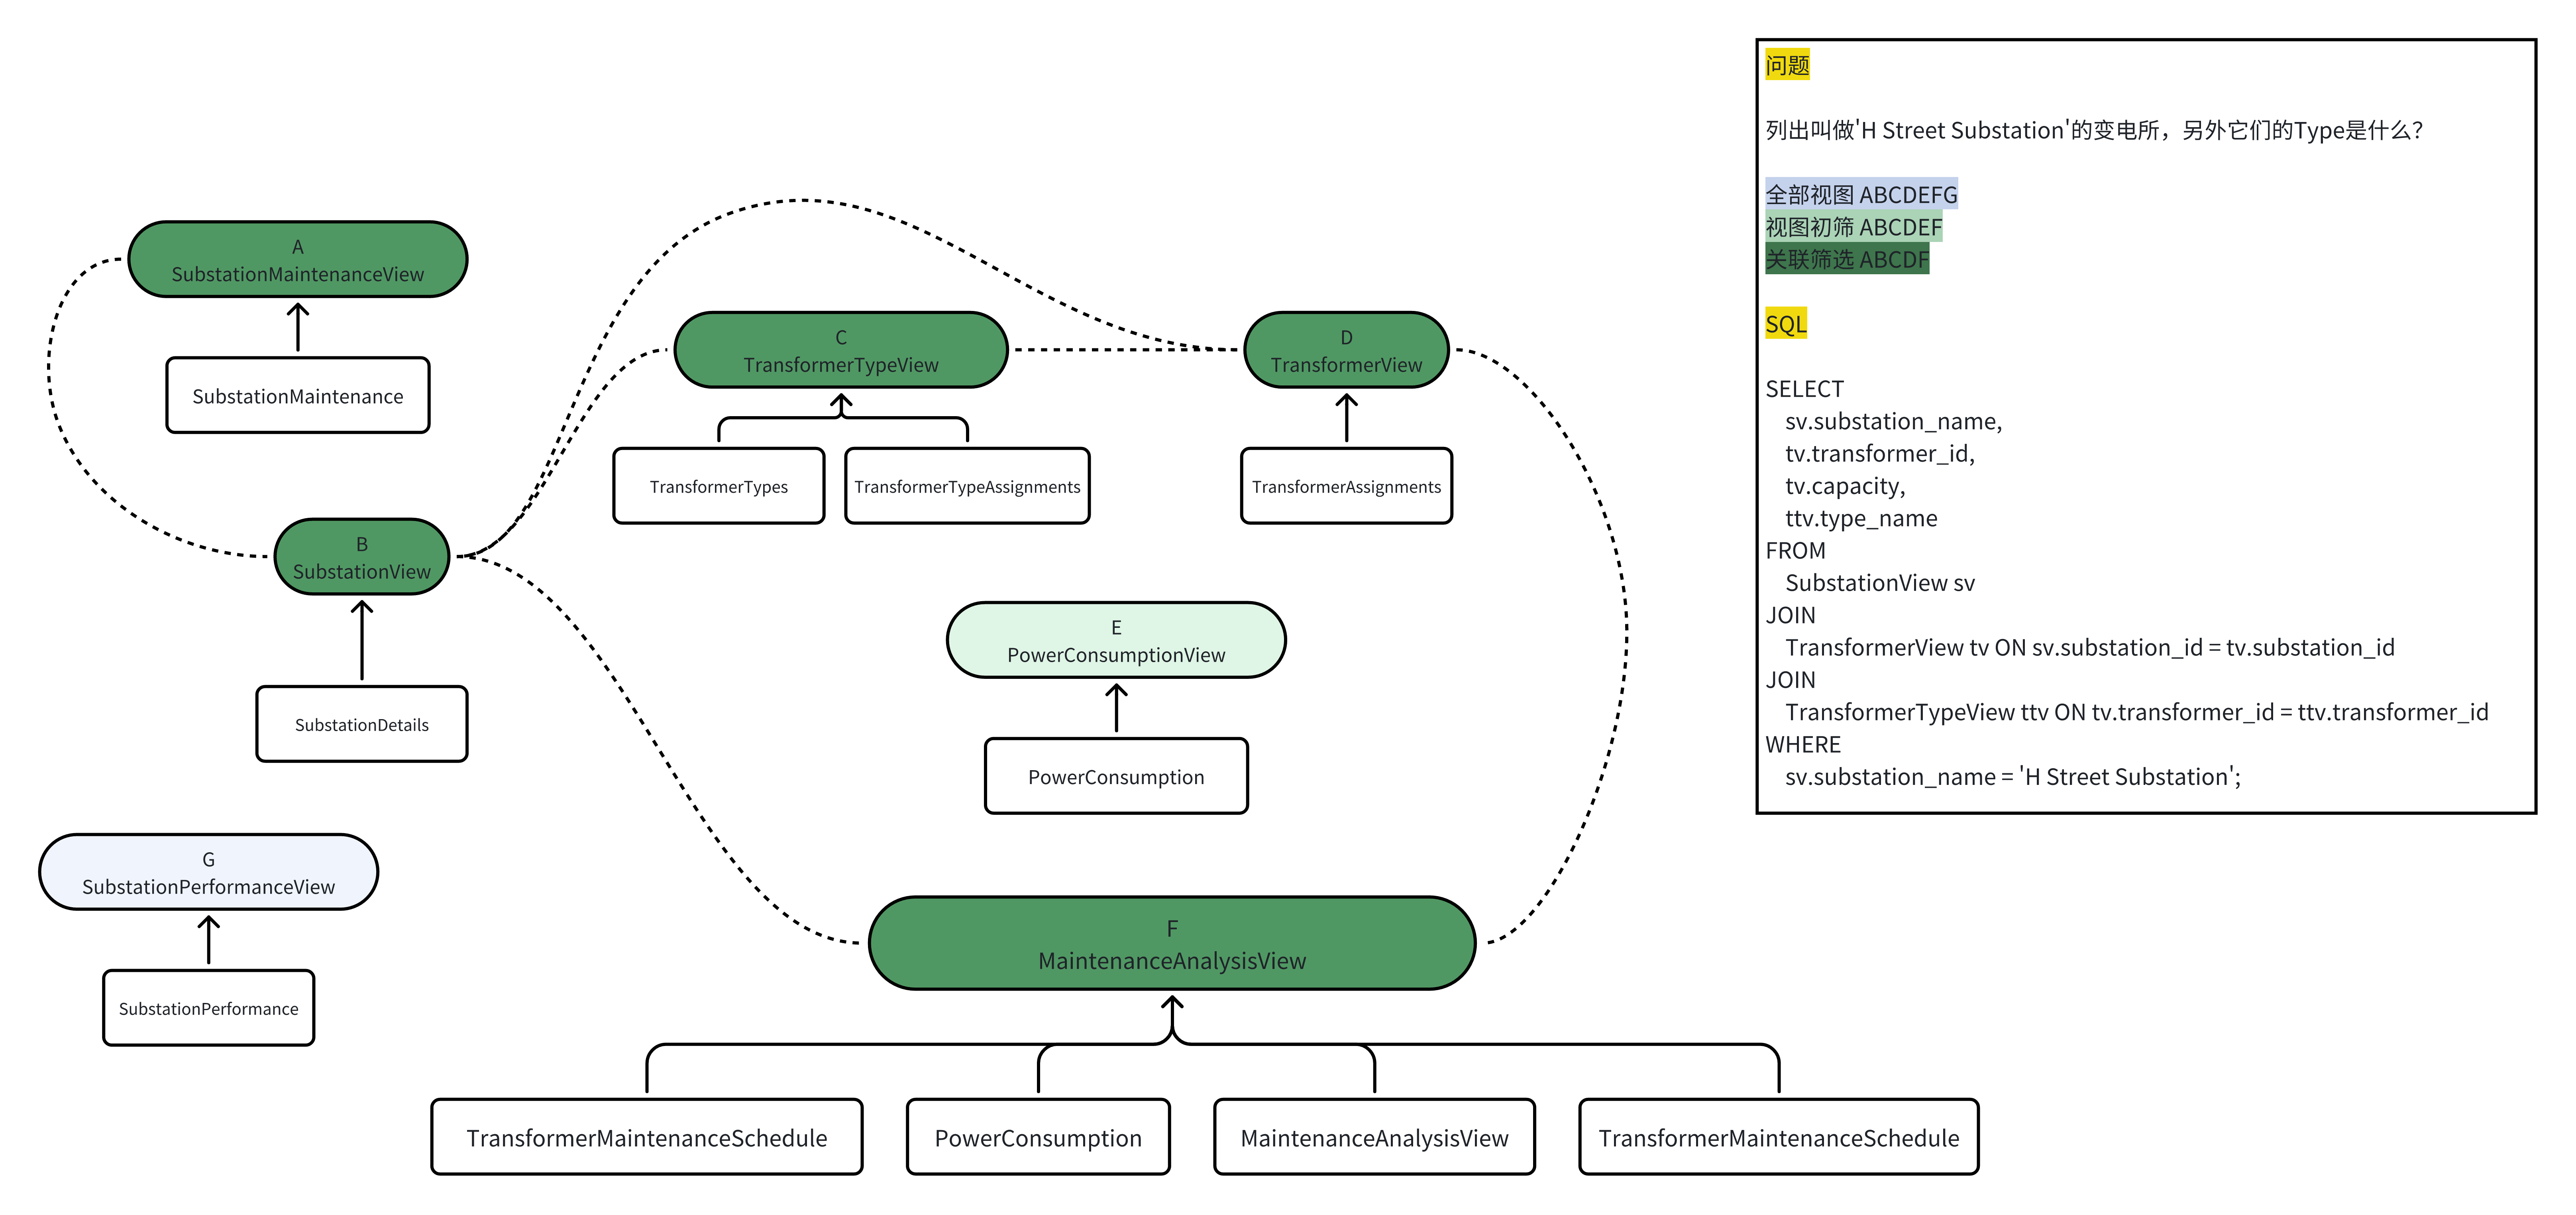

In [3]:
from IPython.display import Image, display

local_image = Image(filename='schema.png')
display(local_image)

# Schema example

In [4]:
import sqlite3

# Connect to the SQLite database
conn = sqlite3.connect('viewsift2.db')
cursor = conn.cursor()

# Function to get foreign key relations and base table
def get_foreign_key_relations(cursor, table_name):
    cursor.execute(f"PRAGMA foreign_key_list({table_name})")
    return cursor.fetchall()

def get_base_tables(cursor, view_name):
    cursor.execute(f"SELECT sql FROM sqlite_master WHERE type='view' AND name='{view_name}'")
    sql = cursor.fetchone()[0]
    base_tables = []
    for word in sql.split():
        if word in ["FROM", "JOIN"]:
            base_tables.append(sql.split()[sql.split().index(word) + 1])
    return base_tables

def find_related_views(views):
    related_views = []
    for i in range(len(views)):
        for j in range(i + 1, len(views)):
            base_tables_i = get_base_tables(cursor, views[i])
            base_tables_j = get_base_tables(cursor, views[j])
            for table_i in base_tables_i:
                for table_j in base_tables_j:
                    fk_relations = get_foreign_key_relations(cursor, table_j)
                    for fk_relation in fk_relations:
                        if fk_relation[2] == table_i:
                            related_views.append((views[i], views[j]))
    return related_views

def dfs(graph, node, visited):
    stack = [node]
    connected_component = []
    while stack:
        current = stack.pop()
        if current not in visited:
            visited.add(current)
            connected_component.append(current)
            stack.extend(graph[current])
    return connected_component

# Candidate views
views = ['SubstationView', 'TransformerView', 'TransformerTypeView','MaintenanceAnalysisView','PowerConsumptionView','SubstationMaintenanceView','SubstationPerformanceView']

# Views scores
view_scores = {
    'SubstationView': 1.5,
    'TransformerView': 2.0,
    'TransformerTypeView': 0.8,
    'MaintenanceAnalysisView': 1.2,
    'PowerConsumptionView': 0.5,
    'SubstationMaintenanceView': 2.5,
    'SubstationPerformanceView': 3.0
}

# Find related views
related_views = find_related_views(views)

# Build the graph
graph = {view: [] for view in views}
for view1, view2 in related_views:
    graph[view1].append(view2)
    graph[view2].append(view1)

# Find connected components
visited = set()
components = []
for view in views:
    if view not in visited:
        component = dfs(graph, view, visited)
        components.append(component)

# Calculate the total score for each connected component
threshold = 2.0  # Preset threshold T
component_scores = []
for component in components:
    total_score = sum(view_scores[view] for view in component)
    component_scores.append((component, total_score))

# Find the highest scoring connected component that exceeds the threshold
max_component, max_score = max((comp for comp in component_scores if comp[1] >= threshold), key=lambda x: x[1], default=(None, 0))

if max_component:
    print(f"Maximum Connected Component: \n{max_component} \nTotal Score: {max_score}")
else:
    print("No connected component meets the threshold.")

conn.close()


Maximum Connected Component: 
['SubstationView', 'SubstationMaintenanceView', 'MaintenanceAnalysisView', 'TransformerView', 'TransformerTypeView'] 
Total Score: 8.0
